# Compare $W(k, k^{\prime}) \times P_{\mathrm{cubic}}(k^{\prime})$ with/without $r_{\perp}$-cut

In [1]:
import os
import sys

import numpy as np
from matplotlib import pyplot as plt

from desilike.samples import Profiles

sys.path.append('../bin')
from utils import load_poles, load_poles_list
from desi_file_manager import DESIFileName
from local_file_manager import LocalFileName

# plotting
plt.style.use(os.path.join(os.path.abspath('../bin'), 'plot_style.mplstyle'))
plots_dir = '../../plots/'

### Global parameters

In [2]:
# tracer
tracer = 'ELG'
region = 'SGC'
completeness = False

# mocks/version
version = 'v3'
imocks = range(25)

# multipoles
ells = (0, 2, 4)
ktmax = 0.5
krange = (0., 0.2, 0.005)

# cut
rpcut = 0.
thetacut = 0.05

## $P_{\mathrm{cubic}}(k)$

In [3]:
fn = LocalFileName()
fn.set_default_config(mockgen='cubic', tracer=tracer, region=region)
cubic_pk = load_poles_list([fn.get_path(realization=imock, los=los) for los in ('xyz') for imock in range(25)])

### Model fitted on $P_{\mathrm{cubic}}(k)$

In [4]:
data_dir = '/global/cfs/cdirs/desi/users/mpinon/cubicSecondGenMocks/'

template_name = 'shapefitqisoqap'

emulator_dir = os.path.join(data_dir, 'emulators/test/emulators_{}_ELG'.format(template_name))
profiles_dir = os.path.join(data_dir, 'profiles/cubicsecondgenmocks/profiles_{}_ELG_complete'.format(template_name))
profile_cubic = Profiles.load(os.path.join(profiles_dir, 'power_velocileptors.npy'))

## Window matrix $W(k, k^{\prime})$ with/without $r_{\perp}$-cut

In [5]:
from pypower import BaseMatrix

wm_fn = DESIFileName()
wm_fn.set_default_config(version=version, ftype='wmatrix_smooth', tracer=tracer, region=region, completeness=completeness, realization='merged', weighting='_default_FKP')
wm = BaseMatrix.load(wm_fn.get_path())

wm_rpcut = BaseMatrix.load(wm_fn.get_path(rpcut=rpcut, thetacut=thetacut))

koutrebin = 1

for w in [wm, wm_rpcut]:
    w.slice_x(sliceout=slice(0, len(w.xout[0]) // koutrebin * koutrebin, koutrebin))
    w.select_x(xoutlim=(krange[0], krange[1]))
    kinrebin = 10
    w.slice_x(slicein=slice(0, len(w.xin[0]) // kinrebin * kinrebin, kinrebin))
    w.select_x(xinlim=(0.005, ktmax))

### Theory from fitted on $P_{\mathrm{cubic}}(k)$

In [6]:
from emulator_fit import get_fit_setup, get_template
from desilike.theories.galaxy_clustering import LPTVelocileptorsTracerPowerSpectrumMultipoles

z, b0, klim, slim = get_fit_setup(tracer='ELG', theory_name='velocileptors')
for lim in klim.values():
    lim[1] = krange[1]
from cosmoprimo.fiducial import DESI
fiducial = DESI()
b1E = b0 / fiducial.growth_factor(z)

template = get_template(template_name=template_name, z=z)

theory = LPTVelocileptorsTracerPowerSpectrumMultipoles(template=template, ells=klim.keys(), k=wm.xin[0])
pk_theory = theory(**profile_cubic.bestfit.choice(input=True))

/global/common/software/desi/users/adematti/perlmutter/cosmodesiconda/20231013-1.0.0/code/cosmoprimo/main/lib/python3.10/site-packages/cosmoprimo/eisenstein_hu.py:23: UserWarning: EisensteinHuNoWiggleEngine cannot cope with massive neutrinos
  warnings.warn('{} cannot cope with massive neutrinos'.format(self.__class__.__name__))


### $W(k, k^{\prime}) \times P_{\mathrm{theory}}(k^{\prime})$

In [7]:
wm_pk = (wm.value.T.dot(pk_theory.flatten())).reshape((len(ells), wm.shape[1]//len(ells)))
wm_pk_rpcut = (wm_rpcut.value.T.dot(pk_theory.flatten())).reshape((len(ells), wm_rpcut.shape[1]//len(ells)))

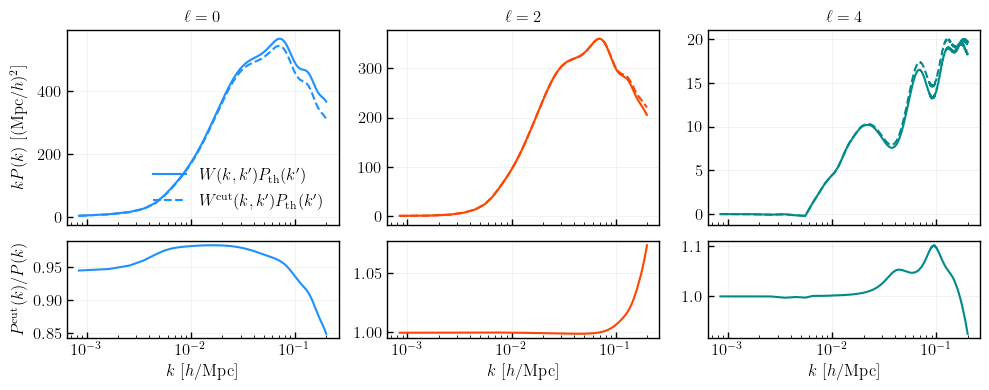

In [8]:
fig, axes = plt.subplots(2, 3, figsize=(10, 4), sharey=False, sharex=True, gridspec_kw={'height_ratios': [4, 2]})

for ill, ell in enumerate(ells):
    axes[0][ill].plot(wm.xout[ill], wm.xout[ill] * wm_pk[ill], color='C{}'.format(ill), label=r'$W(k, k^{\prime}) P_{\mathrm{th}}(k^{\prime})$')
    axes[0][ill].plot(wm_rpcut.xout[ill], wm_rpcut.xout[ill] * wm_pk_rpcut[ill], color='C{}'.format(ill), ls='--', label=r'$W^{\mathrm{cut}}(k, k^{\prime}) P_{\mathrm{th}}(k^{\prime})$')
    axes[0][ill].set_title(r'$\ell={}$'.format(ell))

    axes[1][ill].plot(wm.xout[ill], wm_pk_rpcut[ill]/wm_pk[ill], color='C{}'.format(ill))
    axes[1][ill].set_xlabel(r'$k$ [$h$/Mpc]')
    axes[1][ill].set_xscale('log')
    
axes[0][0].set_ylabel(r'$k P(k)$ [$(\mathrm{Mpc}/h)^{2}$]')
axes[1][0].set_ylabel(r'$P^{\mathrm{cut}}(k) / P(k)$')
axes[0][0].legend()
fig.align_ylabels()
plt.show()

In [13]:
fn = DESIFileName()
fn.set_default_config(version=version, tracer=tracer, region=region, rpcut=0, completeness=completeness, weighting='_default_FKP')
cutsky_pk = load_poles_list([fn.get_path(realization=imock) for imock in range(25)], rebin=5)
cutsky_pk_rpcut = load_poles_list([fn.get_path(realization=imock, rpcut=rpcut, thetacut=thetacut) for imock in range(25)], rebin=5)

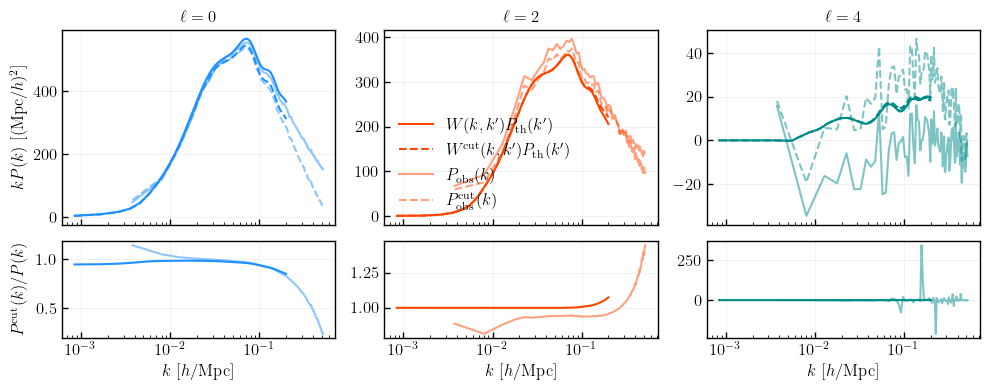

In [14]:
fig, axes = plt.subplots(2, 3, figsize=(10, 4), sharey=False, sharex=True, gridspec_kw={'height_ratios': [4, 2]})

for ill, ell in enumerate(ells):
    axes[0][ill].plot(wm.xout[ill], wm.xout[ill] * wm_pk[ill], color='C{}'.format(ill), label=r'$W(k, k^{\prime}) P_{\mathrm{th}}(k^{\prime})$')
    axes[0][ill].plot(wm_rpcut.xout[ill], wm_rpcut.xout[ill] * wm_pk_rpcut[ill], color='C{}'.format(ill), ls='--', label=r'$W^{\mathrm{cut}}(k, k^{\prime}) P_{\mathrm{th}}(k^{\prime})$')
    axes[0][ill].plot(cutsky_pk['k'][ill], cutsky_pk['k'][ill] * cutsky_pk['data'][ill], color='C{}'.format(ill), alpha=0.5, label=r'$P_{\mathrm{obs}}(k)$')
    axes[0][ill].plot(cutsky_pk_rpcut['k'][ill], cutsky_pk_rpcut['k'][ill] * cutsky_pk_rpcut['data'][ill], color='C{}'.format(ill), alpha=0.5, ls='--', label=r'$P_{\mathrm{obs}}^{\mathrm{cut}}(k)$')
    axes[0][ill].set_title(r'$\ell={}$'.format(ell))

    axes[1][ill].plot(wm.xout[ill], wm_pk_rpcut[ill]/wm_pk[ill], color='C{}'.format(ill))
    axes[1][ill].plot(cutsky_pk['k'][ill], cutsky_pk_rpcut['data'][ill]/cutsky_pk['data'][ill], color='C{}'.format(ill), alpha=0.5)
    axes[1][ill].set_xlabel(r'$k$ [$h$/Mpc]')
    axes[1][ill].set_xscale('log')
    
axes[0][0].set_ylabel(r'$k P(k)$ [$(\mathrm{Mpc}/h)^{2}$]')
axes[1][0].set_ylabel(r'$P^{\mathrm{cut}}(k) / P(k)$')
axes[0][1].legend()
fig.align_ylabels()
plt.show()